In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import branca
import folium
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

## Import files

In [ ]:
# Full database
# df is still the sample csv, need to be changed with the full dataset filtered on stations from Rotterdam to the Hague
df = pd.read_csv('prog en realisatie ophalen - sample1.csv') 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")

#Small database for testing
df= df.head(1000)

Note that the graphical outputs are incomplete due to the fact that it is only the sample dataset for the moment

Associate each station to it's geometry

In [17]:
stations_codes = stations_codes.merge(
    gdf_points[["name","geometry"]], 
    left_on="Commercial Name", 
    right_on="name")
stations_codes = gpd.GeoDataFrame(stations_codes, geometry='geometry')

Split the fied TRAJECT in two separate fields to get Origin and Destination station, and to get their geometries

In [18]:
df["Origin_station"] = df["TRAJECT"].str.split("_").str[0]
df["Destination_station"] = df["TRAJECT"].str.split("_").str[1]

df = df.merge(
        stations_codes, 
        left_on="Origin_station",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Origin_com_name", 
            "Code" : "Origin_code",
            "geometry" : "geometry_origin"
            })
    
df = df.merge(
        stations_codes, 
        left_on="Destination_station",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Destin_com_name", 
            "Code" : "Destin_code",
            "geometry" : "geometry_destination"
            })


Create a table gdf_segments that contains all the informations about a segments (geometry, crowding)

In [19]:
gdf_segments = df[["TRAJECT","geometry_origin", "geometry_destination","Origin_com_name","Destin_com_name","Origin_code","Destin_code"]].drop_duplicates()
gdf_segments['geometry'] = gdf_segments.apply(
    lambda row: LineString([row['geometry_origin'], row['geometry_destination']]), 
    axis=1
)
gdf_segments = gpd.GeoDataFrame(gdf_segments, geometry='geometry')

crowding_by_traject = df.groupby("TRAJECT")[["REALISATIE","PROGNOSE_REIZEN","AFWIJKING"]].sum().reset_index()
gdf_segments = gdf_segments.merge(
    crowding_by_traject,
    left_on="TRAJECT",
    right_on="TRAJECT",
    how="left"
)
gdf_segments["crowding"] = gdf_segments["REALISATIE"]
gdf_segments = gdf_segments.set_crs("EPSG:4326", allow_override=True)


# Map

Note that GitHub does not print the map in the preview, it needs to be run in VS Code

In [21]:
# create learn colormap interpolating 3 colors
colors = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'], vmin=gdf_segments["crowding"].min(), vmax=gdf_segments["crowding"].max())

def weight (val, min_weight, max_weight) : 
    vmin=gdf_segments["crowding"].min()
    vmax=gdf_segments["crowding"].max()
    norm = (val - vmin) / (vmax - vmin)
    return min_weight + norm * (max_weight - min_weight)

# define style function
def raster_choropleth(row):
    return {
        #"fillColor": colors(row['properties']['avg']),
        "color": colors(row['properties']['crowding']),
        "weight": weight (row['properties']['crowding'], 2, 5),
        "fillOpacity": 0.75,
    }

# create base map
# The map is centered on The Hague
poly_map = folium.Map(
        location=[52.05, 4.19],    
        zoom_start=7
    )

# overlay choropleth
gjson = folium.features.GeoJson(
    gdf_segments[['TRAJECT', 'crowding', 'geometry']],
    style_function=raster_choropleth,
    ).add_to(poly_map)

# add Tooltip
folium.features.GeoJsonTooltip(
    fields=['TRAJECT','crowding'],
    aliases=['Segment', 'Crowding']
).add_to(gjson)

# add colormap to the map
poly_map.add_child(colors)

# display
poly_map

Future improvements : 
- Divide the high-speed lines onto the intermediate segments to see the crowding on each proper segment
- Add more parameters : selection of the time interval to agregate on,....

# Average deviation per route (bar chart)

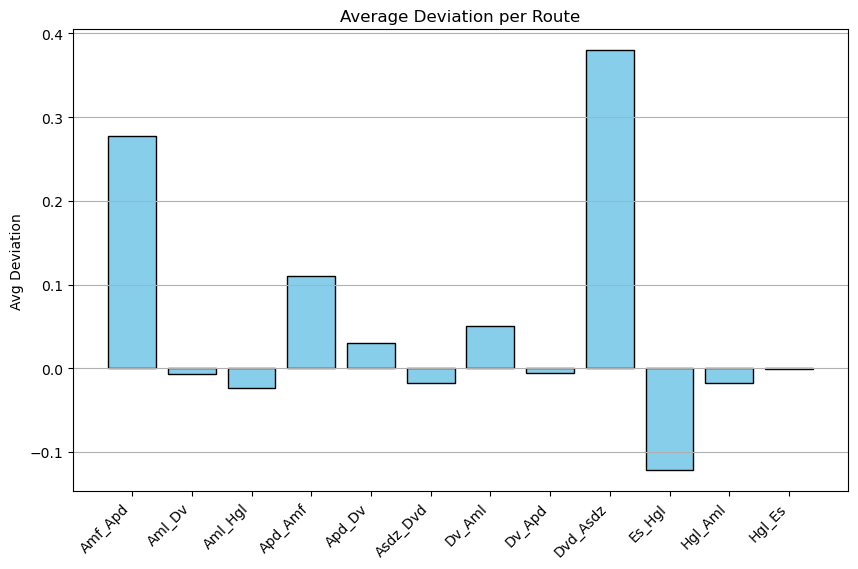

In [22]:
# Group by route
route_stats = df.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean"
}).reset_index()

plt.figure(figsize=(10,6))
plt.bar(route_stats["TRAJECT"], route_stats["AFWIJKING"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg Deviation")
plt.title("Average Deviation per Route")
plt.grid(axis="y")
plt.show()

# Average deviation per route (map)

Note that GitHub does not print the map in the preview, it needs to be run in VS Code

In [23]:
gdf_route_stats = gdf_segments.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean", 
    "geometry" : "first",
}).reset_index()

gdf_route_stats = gpd.GeoDataFrame(gdf_route_stats, geometry='geometry')
gdf_route_stats = gdf_route_stats.set_crs("EPSG:4326", allow_override=True)


In [24]:
# create learn colormap interpolating 3 colors
colors = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'], vmin=gdf_route_stats["AFWIJKING"].min(), vmax=gdf_route_stats["AFWIJKING"].max())

def weight (val, min_weight, max_weight) : 
    vmin=gdf_route_stats["AFWIJKING"].min()
    vmax=gdf_route_stats["AFWIJKING"].max()
    norm = (val - vmin) / (vmax - vmin)
    return min_weight + norm * (max_weight - min_weight)

# define style function
def raster_choropleth(row):
    return {
        #"fillColor": colors(row['properties']['avg']),
        "color": colors(row['properties']["AFWIJKING"]),
        "weight": weight (row['properties']["AFWIJKING"], 2, 5),
        "fillOpacity": 0.75,
    }

# create base map
# The map is centered on The Hague
poly_map = folium.Map(
        location=[52.05, 4.19],    
        zoom_start=7
    )

# overlay choropleth
gjson = folium.features.GeoJson(
    gdf_route_stats[['TRAJECT', "AFWIJKING", 'geometry']],
    style_function=raster_choropleth,
    ).add_to(poly_map)

# add Tooltip
folium.features.GeoJsonTooltip(
    fields=['TRAJECT',"AFWIJKING"],
    aliases=['Segment', 'Average deviation per route']
).add_to(gjson)

# add colormap to the map
poly_map.add_child(colors)

# display
poly_map

# Quality of previsions through the day

We group the realised departures times in 10-minutes intervals

In [26]:
# Creation of multiple time intervals to group the trips

# skip the decimal part
df["round_UITVOERTIJD_AANKOMST"] = (
    df["UITVOERTIJD_AANKOMST"]
    .str.split('.')
    .str[0]  
)
# convert to datetime
df["round_UITVOERTIJD_AANKOMST"] = pd.to_datetime(df["round_UITVOERTIJD_AANKOMST"], format='%H:%M:%S').dt.time

# We create a new feature to group the real departure times by 10-minutes intervals 
def round_time_to_interval(t,interval=10):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-minutes intervals)
    Retunrs : 
        rounded time in date format
    """
    dt = datetime.combine(datetime.today(), t)
    total_minutes = dt.hour * 60 + dt.minute
    rounded_minutes = round(total_minutes / interval) * interval
    dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(minutes=rounded_minutes)
    return dt_rounded.time()

df["round_UITVOERTIJD_AANKOMST"] = df["round_UITVOERTIJD_AANKOMST"].apply(lambda t : round_time_to_interval(t,10))

mean_deviation = df.groupby('round_UITVOERTIJD_AANKOMST').agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
}).reset_index()



And plot the diagram

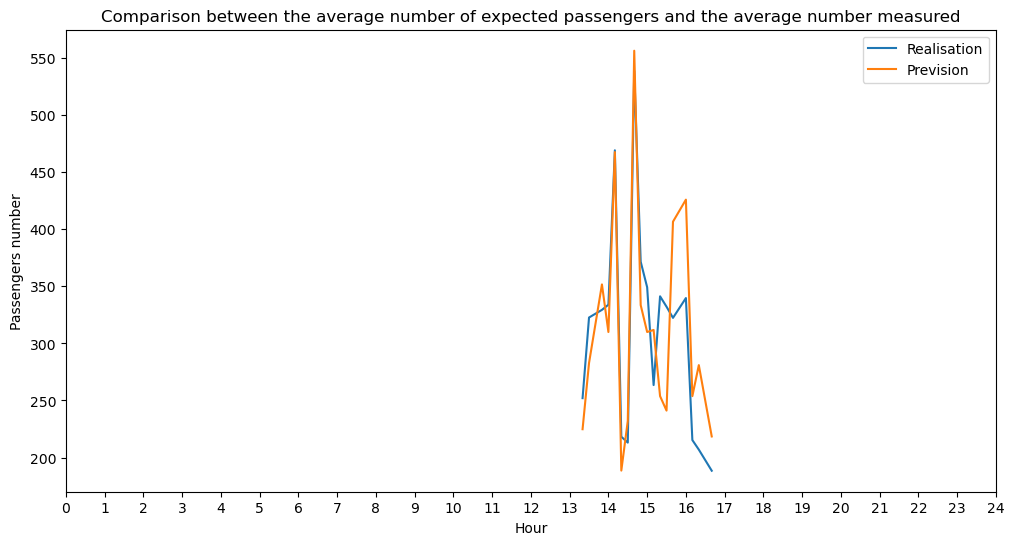

In [27]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)
mean_deviation['minutes'] = mean_deviation['round_UITVOERTIJD_AANKOMST'].apply(
    lambda t: t.hour * 60 + t.minute
)

# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_deviation['minutes'], mean_deviation['REALISATIE'], label='Realisation')
plt.plot(mean_deviation['minutes'], mean_deviation['PROGNOSE_REIZEN'], label='Prevision')

plt.xticks(range(0, 24*60+1, 60), [f"{h}" for h in range(25)])  # ticks every hours
plt.xlabel("Hour")
plt.ylabel("Passengers number")
plt.title("Comparison between the average number of expected passengers and the average number measured")
plt.legend()
plt.show()